<a href="https://colab.research.google.com/github/snowman74/Neural-Networks/blob/main/%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F%20%D0%BD%D0%B0%20%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%B5%20%D0%BF%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D1%8F%20%D1%86%D0%B5%D0%BD%20%D0%BD%D0%B0%20%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи регрессии для предсказания цены на квартиры

In [ ]:
import pandas as pd
from google.colab import files
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import matplotlib.pyplot as plt
%matplotlib inline

from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dropout, Dense, BatchNormalization, Flatten, Conv1D, Conv2D

In [ ]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр
  
  
  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами
  
  #идём по всем символам
  for symbol in text:
    
    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""): 
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)
  
  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):
  
  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []
  
  #Идём по всем словая
  for word in words:
    
    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре
    
    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0
        
    wordsIndexes.append(wordIndex)
    
  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)
  
  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1
    
  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []
  
  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words
    
  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря
  
  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try: 
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку
  
  xTrainComments = np.array(xTrainComments)
  
  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов
  
  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain
  
  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

In [ ]:
files.upload()
!ls

drive  sample_data


In [ ]:
df_moscow = pd.read_csv('/content/drive/My Drive/Базы/moscow.csv', sep=';')
df_moscow = df_moscow.iloc[::2,:]  
data = df_moscow.values
# oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data]
# data1 = data[oneRoomMask]
print(data.shape)
# print(data1.shape)

(126268, 14)


In [ ]:
print(df_moscow.iloc[:, :6].head(20))

   Комнат        Метро / ЖД станции От станции        Дом Балкон Санузел
0       1               Шелепиха м.        12п    35/37 М    NaN       2
2       1        Пятницкое шоссе м.        30т    11/14 П      Л       Р
4       1              Планерная м.         5т    11/22 П      Б       С
6       1            Шаболовская м.        12п     8/12 ?      Б       Р
8       1           Бабушкинская м.        15п     4/14 П    NaN       С
10      1               Шелепиха м.        15п     9/36 К    NaN     NaN
12      1    Улица Дмитриевского м.         2п     7/16 П      Л       Р
14      1  Бульвар Рокоссовского м.         2п      2/5 К      Б       С
16      1           Марьина Роща м.        10п     7/14 П     2Б     NaN
18      1                Марьино м.        20п  10/24 М-К    NaN       -
20      1                Марьино м.         5т      5/5 П      Б       С
22      1              Печатники м.         5т     2/12 П      -       С
24      1      Красногвардейская м.         3п    2

In [ ]:
print(df_moscow.columns)

Index(['Комнат', 'Метро / ЖД станции', 'От станции', 'Дом', 'Балкон',
       'Санузел', 'Площадь', 'Цена, руб.', 'ГРМ', 'Бонус агенту', 'Дата',
       'Кол-во дней в экспозиции', 'Источник', 'Примечание'],
      dtype='object')


In [ ]:
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0]

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr)
    if (roomsCOunt > maxRoomCount):
      roomsCount = maxRoomCount
  except:
    if (roomsCountStr == roomsCountStr):
      if ('Ст' in roomsCountStr):
        roomsCount = maxRoomCount + 1

  return roomsCount

def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount)
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount + 2)
  return roomsCount

def getMetro(d, allMetroNames):
  metroStr = d[1]
  metro = 0

  if (metroStr in allMetroNames):
    metro = allMetroNames.index(metroStr) + 1

  return metro

def getMetroType(d):
  metroTypeStr = d[1]
  metroTypeClasses = 5
  metroType = metroTypeClasses - 1

  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]
  
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3
  
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType

def getMetroDistance(d):
  metroDistanceStr = d[2]

  metroDistance = 0
  metroDistanceType = 0 

  if (metroDistanceStr == metroDistanceStr):
    if len(metroDistanceStr) > 0:
      if (metroDistanceStr[-1] == 'п'):
        metroDistanceType = 1
      elif (metroDistanceStr[-1] == 'т'):
        metroDistanceType = 2
      
      metroDistanceStr = metroDistanceStr[: -1]
      try:
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 0
      except:
        metroDistance = 0

  metroDistanceClasses = 7

  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses
  
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3]
  except:
    houseStr = ''
  
  houseType = 0
  floor = 0
  floors = 0
  isLastFloor = 0

  if (houseStr == houseStr):
    if (len(houseStr) > 1):
      try:
        slashIndex = houseStr.index('/')
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(' ')
      except:
        print(houseStr)
      
      floorStr = houseStr[:slashIndex]
      floorsStr = houseStr[slashIndex + 1: spaceIndex]
      houseTypeStr = houseStr[spaceIndex + 1:]

      try:
        floor = int(floorStr)
        floorSave = floor
        if floorSave < 5:
          floor = 2
        if floorSave < 10:
          floor = 3
        if floorSave < 20:
          floor = 4
        if floorSave >= 20:
          floor = 5
        if floorSave == 1:
          floor = 1
        
        if floor == floors:
          isLastFloor = 1
      except:
        floor = 0  
      
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr): 
          houseType = 1
        if ("К" in houseTypeStr): 
          houseType = 2
        if ("П" in houseTypeStr): 
          houseType = 3
        if ("Б" in houseTypeStr): 
          houseType = 4
        if ("?" in houseTypeStr): 
          houseType = 5
        if ("-" in houseTypeStr): 
          houseType = 6
        
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)
  
  return floor, floors, isLastFloor, houseType

def getBalcony(d):
  balconyStr = d[4] 
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr) + 1
  else:
    balcony = 0
  
  
  balcony = utils.to_categorical(balcony, 16)
  
  return balcony

def getWC(d):
  wcStr = d[5]
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  if wcStr == wcStr:
    wc = wcVariants.index(wcStr) + 1
  else:
    wc = 0

  wc = utils.to_categorical(wc, 14)
  return wc

def getArea(d):
  areaStr = d[6]

  if ('/' in areaStr):
    slashIndex = areaStr.index('/')
    try:
      area = float(areaStr[:slashIndex])
    except:
      area = 0
  else:
    area = 0

  return area

def getCost(d):
  costStr = d[7]

  try:
    cost = float(costStr)
  except:
    cost = 0

  return cost

def getComment(d):
  commentStr = d[-1]
  return commentStr

def getAllParameters(d, allMetroNames):
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(wc)
  out.append(area)

  return out

def getXTrain(data):

  allMetroNames = list(df_moscow['Метро / ЖД станции'].unique())

  xTrain = [getAllParameters(d, allMetroNames) for d in data]
  xTrain = np.array(xTrain)

  return xTrain

def getYTrain(data):
  costList = [getCost(d) for d in data]
  yTrain = np.array(costList)

  return yTrain

In [ ]:
# Загружаем числовые данные
xTrain = getXTrain(data)
yTrain = getYTrain(data)

In [ ]:
tokenizer = Tokenizer(num_words=2000, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)

In [ ]:
def getXTrainComments(data):
  xTrainC = [getComment(d) for d in data]
  xTrainC = np.array(xTrainC)
  return xTrainC

In [ ]:
xTrainC = getXTrainComments(data)

In [ ]:
xTrainC

array(['Собственность оформлена! Ключи на руках! Оперативный показ и выход на сделку! Свободная продажа! Предлагаем приобрести апартаменты премиального уровня в ЖК «Сердце столицы» с шикарными видовыми характеристиками (смотрите фото), таких предложений в данном ЖК - нет! Реальные живые фото, из личного архива! Закрытая территория, уютные и безопасные дворы без автомобилей, подземный паркинг с автомойками, имеется м/м за отдельную плату, круглосуточная охрана. Собственная инфраструктура включает фитнес-центр, стадион, беговые и велосипедные дорожки, скейт-парк, йога-центры, летний театр, 500-метровая набережная с пляжной зоной и причалом, на территории будет располагаться собственная школа и детский сад и т.д. В шаговой доступности метро: Шелепиха, Международная, Деловой центр, Выставочная, Фили. Удобная транспортная доступность. Звоните! Может именно это предложение Вы уже давно ищете!',
       'Зеленоград к.1820 однокомнатная квартира общ.38.4/17/9  ( Общая с учетом лоджии 41 кв.м.) 

In [ ]:
tokenizer.fit_on_texts(xTrainC)
xTrainC01Indexes = tokenizer.texts_to_sequences(xTrainC)

In [ ]:
xTrainC01 = tokenizer.sequences_to_matrix(xTrainC01Indexes)
xTrainC01

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [ ]:
np.save('/content/drive/My Drive/xTrainC01_moscow.npy',xTrainC01)
np.save('/content/drive/My Drive/xTrainScaled.npy',xTrainScaled)
np.save('/content/drive/My Drive/yTrainScaled.npy',yTrainScaled)

In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

(126268, 86)
[ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.
  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  64.1]
[ 0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.       

In [ ]:
xTrainC01 = np.load('/content/drive/My Drive/xTrainC01_moscow.npy')
xTrainScaled = np.load('/content/drive/My Drive/xTrainScaled.npy')
yTrainScaled = np.load('/content/drive/My Drive/yTrainScaled.npy')

Epoch 1/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0521 - mae: 0.0489 - val_loss: 3.9620 - val_mae: 0.7373
Epoch 2/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0334 - mae: 0.0416 - val_loss: 3.6271 - val_mae: 0.6984
Epoch 3/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0124 - mae: 0.0373 - val_loss: 3.7805 - val_mae: 0.7206
Epoch 4/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0115 - mae: 0.0350 - val_loss: 3.6986 - val_mae: 0.7090
Epoch 5/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0138 - mae: 0.0342 - val_loss: 3.7126 - val_mae: 0.7002
Epoch 6/20
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0084 - mae: 0.0330 - val_loss: 3.8907 - val_mae: 0.7262
Epoch 7/20
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0061 - mae: 0.0317 - val_loss: 3.7574 - val_mae: 0.7109
Epoch 8/20
5000/5000 [==============================] -

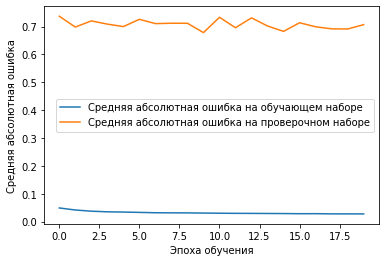

In [ ]:
modelC = Sequential()
modelC.add(Dense(20, activation='relu',input_dim=(xTrainC01.shape[1])))
modelC.add(Dense(500, activation='relu'))
modelC.add(Dropout(0.3))
modelC.add(Dense(1, activation='linear'))
 
modelC.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])
 
history = modelC.fit(xTrainC01[:100000], 
                    yTrainScaled[:100000], 
                    batch_size=20,
                    epochs=20, 
                    validation_data=(xTrainC01[100000:], yTrainScaled[100000:]),
                    verbose=1, shuffle=True)
 
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
splitVal = 0.2                                               #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки
print(xTrainScaled.shape[0])
print(valMask)
print(len(valMask))
np.count_nonzero(valMask)

126268
[ True False False ...  True False False]
126268


25244

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.python.keras.callbacks import LearningRateScheduler
from IPython.display import clear_output
import time

In [ ]:
def getMAE(train_or_validation):
  if train_or_validation:
    mask = ~valMask
  else:
    mask = valMask

    pred = model.predict([xTrainScaled[mask], xTrainC01[mask]])
    predUnscaled = yScaler.inverse_transform(pred).flatten()
    yTrainUnscaled = yScaler.inverse_transform(yTrainUnscaled[mask]).flatten()
    delta = predUnscaled - yTrainUnscaled
    absDelta = abs(delta)
    mae = sum(absDelta) / (1e+6 * len(absDelta))
    return mae

def plotMAE():
  plt.plot(mae_list,
           label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(val_mae_list,
           label='Средняя абсолютная ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя абсолютная ошибка')
  plt.legend()
  plt.show()

def plot_scatter_and_hist(train_or_validation):
  if train_or_validation:
    mask = ~valMask
  else:
    mask = valMask

  pred = model.predict([xTrainScaled[mask], xTrainC01[mask]])
  predUnscaled = yScaler.inverse_transform(yTrainUnscaled[mask].flatten())
  delta = predUnscaled - yTrainUnscaled
  absDelta = abs(delta)

  plt.scatter(yTrainUnscaled[yTrainUnscaled<5e+7], predUnscaled[yTrainUnscaled<5e+7])
  plt.xlabel('Правильные значения')
  plt.ylabel('Предсказания')
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-1e+8, 1e+9], [-1e+8, 1e+9])
  plt.show()

  normalizer_delta = abs(pred - yTrainScaled[valMask])
  bins_norm = [0.01 * i for i in range(20)]
  plt.hist(normalized_delta.flatten(), bins=bins_norm)
  plt.xlabel('Значение ошибки')
  plt.ylabel('Количество')
  plt.show()

mae_list = []
val_mae_list = []
start_time = [time.time()]
epochs_duration = []

def on_epoch_begin(epoch, logs):
  start_time.append(time.time())


a = [0.001]
def sheduler(epoch):
  std = np.array(val_mae_list[-5:]).std()
  print('Среднеквадратичное отклонение', round(std, 4))
  v = 0.001
  if len(val_mae_list) < 5:
    return v

  if (std > 0.2):
    print('Пила, понижаем скорость')
    v = 0.0001
    a.append(v)
    return v

  if (std < 0.002):
    print('Плато, повышаем скорость')
    v = 0.01
    a.append(v)
    return v
  else: return a[-1]


def save_best_model():
  if (len(val_mae_list) < 2):
    model.save('best_net.h5')
  else:
    if (val_mae_list[-1] < np.array(val_mae_list[:-1]).min()):
      model.save('best_net.h5')
      print('Лушая точность, сохраняем нейронку')

def on_epoch_end(epoch, logs):

  mae = getMAE(1)
  val_mae = getMAE(0)
  epochs_duration.append(round(time.time() - start_time[-1], 1))
  all_time = round(time.time() - start_time[0], 1)
  mean_time = sum(epochs_duration) / (epoch + 1)
  estimate_time = round((all_epochs - epoch - 1) * mean_time, 3)
  mae_list.append(mae)
  val_mae_list.append(val_mae)

  clear_output()

  print('Эпоха', epoch)
  print('Модуль ошибки на обучающей выборке', round(mae, 2))
  print('Модуль ошибки на проверочной выборке', round(val_mae, 2))

  print()
  print('Время обучения')
  print('Текущая эпоха -> ', epochs_duration[-1], 'c', sep='')
  print('Суммарное время обучения -> ', all_time, 'c', sep='')
  print('Время до завершения обучения -> ', estimate_time, 'c', sep='')

  plot_scatter_and_hist(0)
  plotMAE()
  save_best_model()

pltMae = LambdaCallback(on_epoch_end=on_epoch_end, on_epoch_begin=on_epoch_begin)
Callback_two = LearningRateScheduler(sheduler)


  

In [ ]:
#Простая Dense сеть
all_epohs = 18
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(5, activation="relu")(input1)
x2 = Dense(25, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(10, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)
Lrate = 1e-3
model.compile(optimizer=Adam(learning_rate=Lrate), loss='mse')



history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]], 
                    yTrainScaled[~valMask], 
                    epochs=all_epohs, 
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]], 
                    yTrainScaled[valMask]), 
                    verbose=0,
                    # callbacks=[pltMae]
                    callbacks=[pltMae, Callback_two]
                    )

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Среднеквадратичное отклонение nan


In [ ]:
my_callBack = LambdaCallback

In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
model = Sequential()
model.add(Dense(5, activation='relu',input_dim=(xTrainC01.shape[1])))
model.add(Dense(1, activation='linear'))
 
model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])
 
history = model.fit(xTrainC01[:1000], 
                    yTrainScaled[:1000], 
                    batch_size=20,
                    epochs=5, 
                    validation_data=(xTrainC01[1000:2000], yTrainScaled[1000:2000]),
                    verbose=0, 
                    callbacks=[pltMae],
                    shuffle=True)
 
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

NameError: ignored